<strong><b><font size="5">Time Series Analysis and Forecasting in Python</font></b></strong>

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importing Data
- Dataset: Monthly Milk Production 

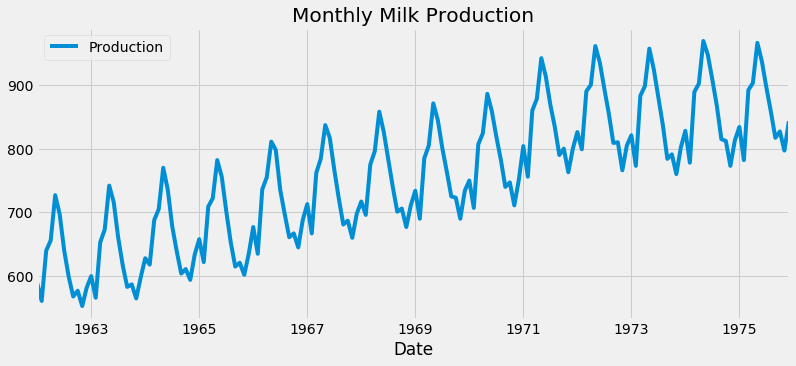

In [32]:
df = pd.read_csv('./monthly_milk_production.csv', sep=',', parse_dates=['Date'], index_col='Date')

df.plot(figsize=(12,5))
plt.title('Monthly Milk Production')
plt.show()

In [33]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [34]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [35]:
df.shape

(168, 1)

# Data Inspection

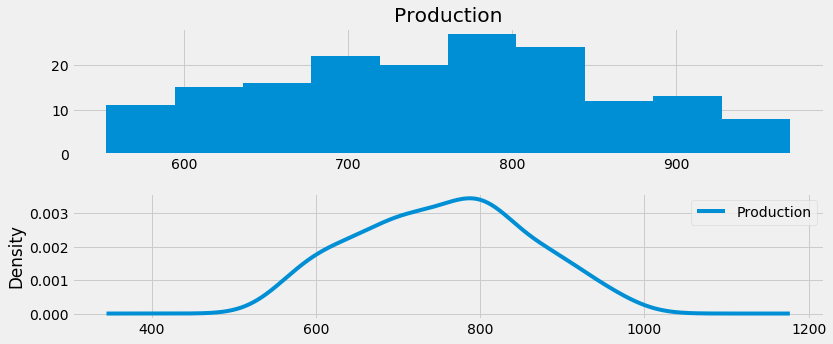

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df.hist(ax=ax1)
df.plot(kind='kde', ax=ax2)
plt.show();

__The distribution is not perfectly Gaussian normal distribution and it is left shifted.__

## Time Series Decomposition

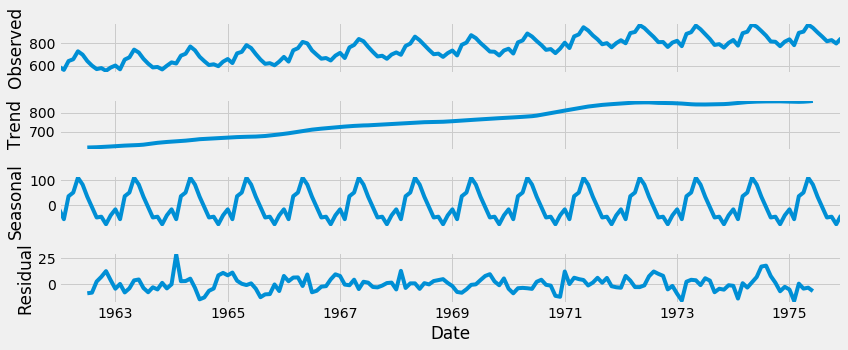

In [37]:
decomposition = seasonal_decompose(df['Production'], freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 5
decomposition.plot()
plt.show();

## Seasonal Component

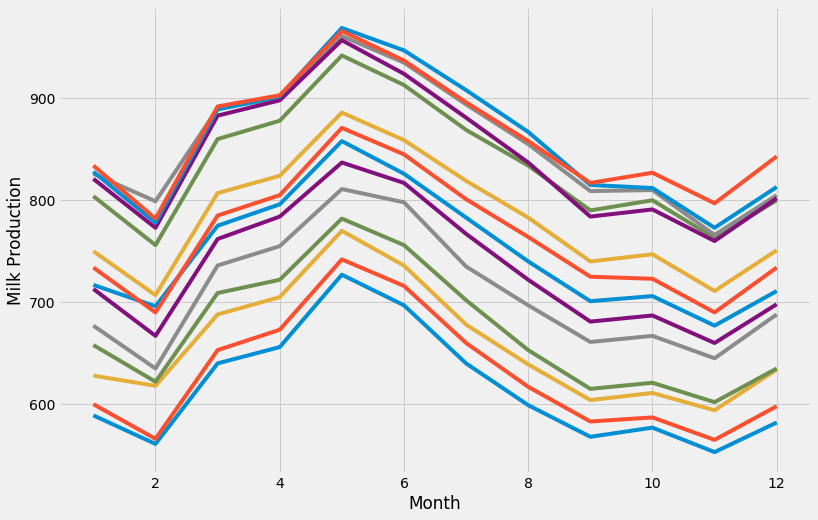

In [38]:
df['year'] = df.index.year
df['month'] = df.index.month
df_pivot = pd.pivot_table(df, values='Production', index='month', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('Milk Production')
plt.show()

In [39]:
df.drop(['year', 'month'], axis=1, inplace=True)

# Model Identification
__Check for Stationarity__

## ACF and PACF plots

__ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick cut off after a small number of lags.__

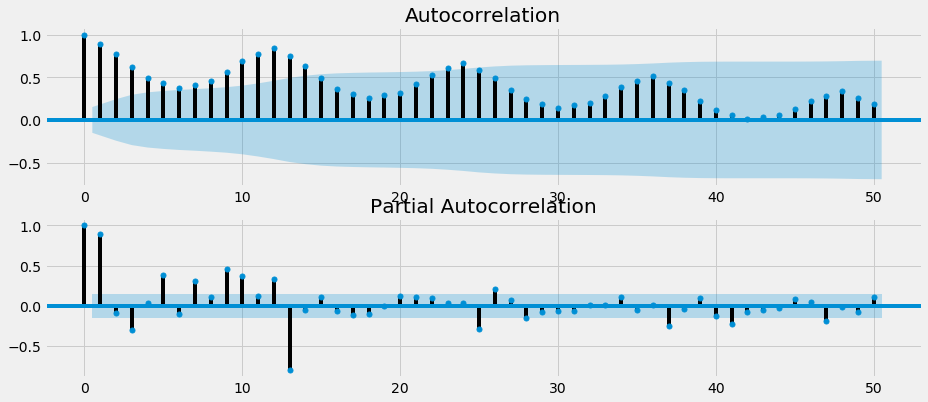

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

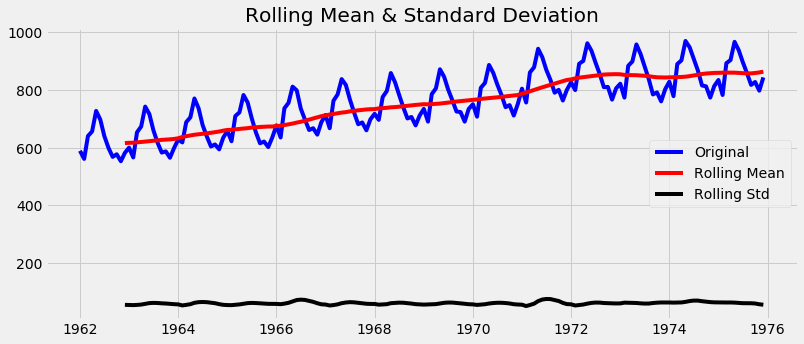

In [41]:
#Determing rolling statistics
rolmean = pd.Series(df['Production']).rolling(window=12).mean()
rolstd = pd.Series(df['Production']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Production'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Statistical Tests

__Augmented Dickey Fuller Test__
If the p-value is lower than the threshold value (5% or 1%), we reject the null hypothesis and time series is stationary. If the p-value is higher than the threshold, we fail to reject the null hypothesis and time series is non-stationary.

In [42]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Production'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


## Making Time Series Stationary

In [43]:
df_diff = df.diff().diff(12)

In [44]:
df_diff.dropna(inplace=True)

In [45]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Production'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.038002
p-value                          0.000019
#Lags Used                      11.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


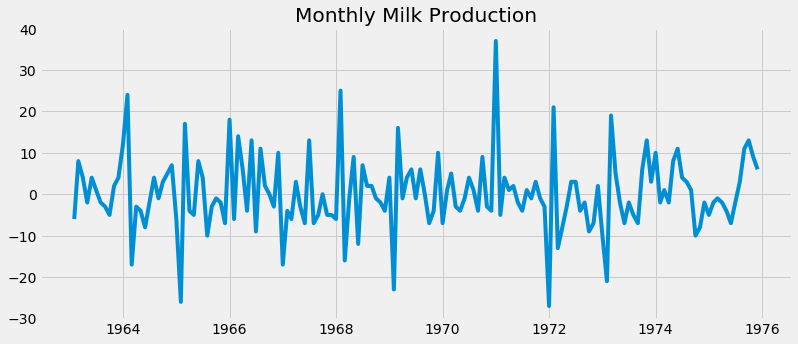

In [46]:
plt.plot(df_diff['Production'])
plt.title('Monthly Milk Production')
plt.savefig('diffplot')
plt.show()

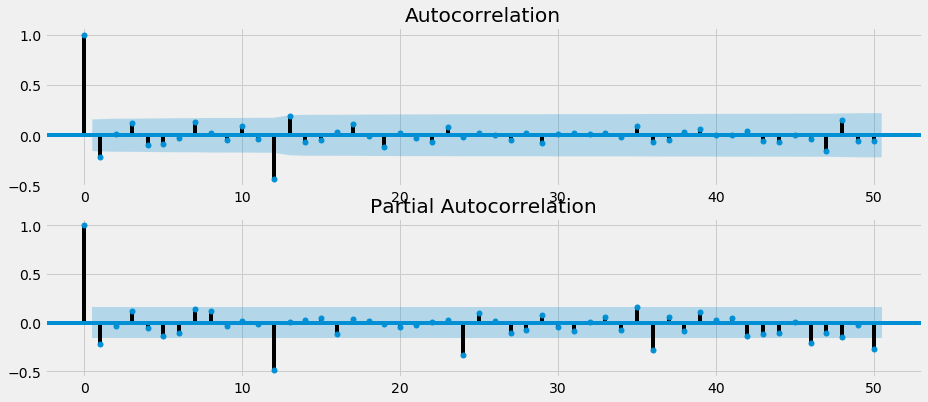

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

# Model Parameter Estimation

In [48]:
import pmdarima as pm
model = pm.auto_arima(df['Production'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)


Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1076.128, BIC=1088.302, Time=0.335 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1121.939, BIC=1128.026, Time=0.028 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1083.569, BIC=1095.742, Time=0.385 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1068.286, BIC=1080.460, Time=0.340 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1121.939, BIC=1128.026, Time=0.019 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1116.950, BIC=1126.081, Time=0.076 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1070.017, BIC=1085.234, Time=0.468 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1069.963, BIC=1085.180, Time=1.037 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1084.109, BIC=1096.282, Time=0.534 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=1071.361,

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -530.100
Date:                            Tue, 02 Jun 2020   AIC                           1068.200
Time:                                    01:13:39   BIC                           1080.374
Sample:                                         0   HQIC                          1073.145
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0211      0.287     -0.074      0.941      -0.584       0.542
ar.L1         -0.2254      0.079     -2.837      0.005      -0.381      -0.070
ma.S.L12      -0.6193      0.071     -8.694      0.000      -0.759      -0.480
sigma2        52.6875      5.100     10.332      0.000      42.693      62.682
===================================================================================
Ljung-Box (Q):                       22.09   Jarque-Bera (JB):                35.11
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

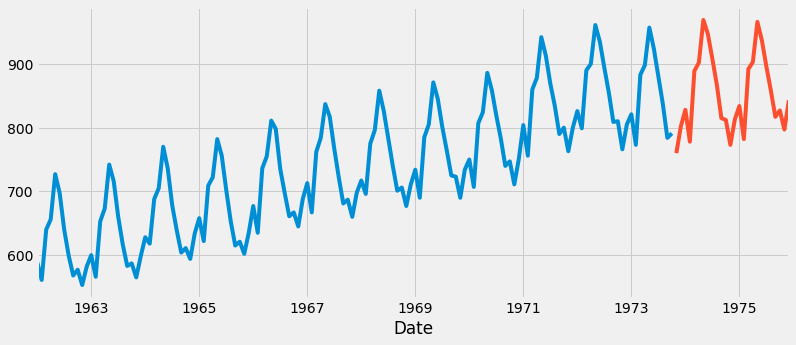

In [50]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train['Production'].plot()
test['Production'].plot()

In [51]:
model = SARIMAX(train['Production'],order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -445.603
Date:                            Tue, 02 Jun 2020   AIC                            897.205
Time:                                    01:13:39   BIC                            905.785
Sample:                                01-01-1962   HQIC                           900.691
                                     - 10-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.6158      0.086     -7.163      0.000      -0.784      -0.447
sigma2        56.0243      5.765      9.719      0.000      44.726      67.323
===================================================================================
Ljung-Box (Q):                       24.06   Jarque-Bera (JB):                40.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.86
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Statistical Model Checking

__Model Diagnostics__

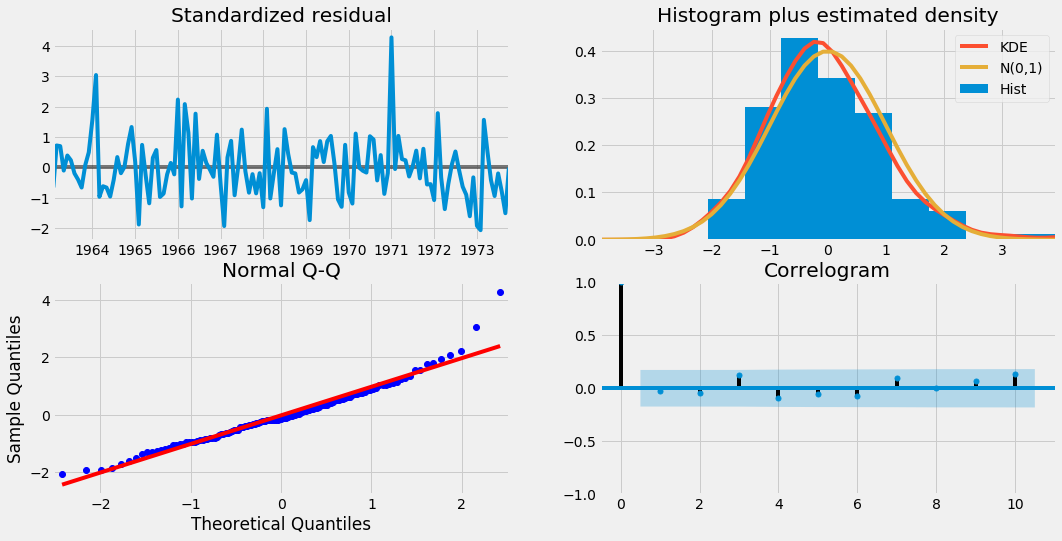

In [52]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [53]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

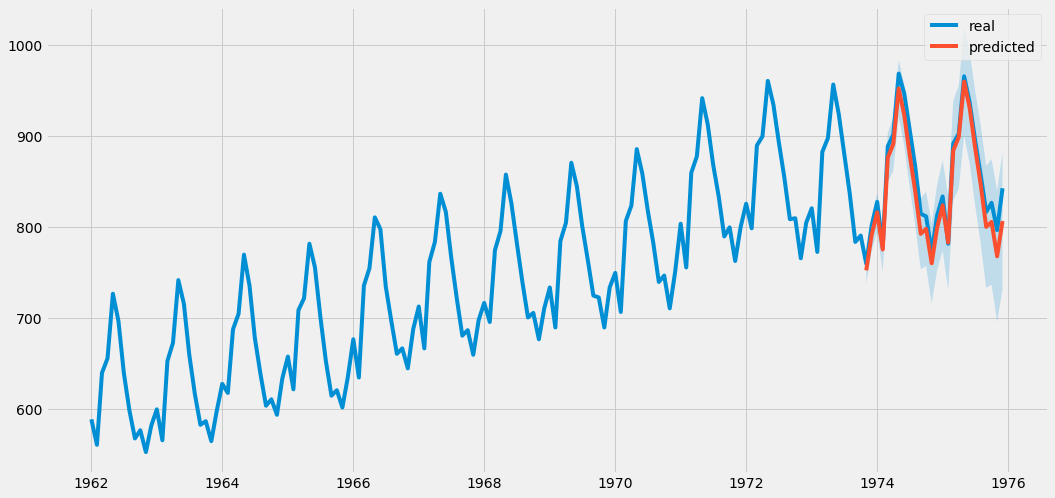

In [54]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [55]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')

In [56]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Production'][i]}")

predicted=752.7789607, expected=760
predicted=791.7112654, expected=802
predicted=816.606986 , expected=828
predicted=775.7138794, expected=778
predicted=876.5424634, expected=889
predicted=891.6737752, expected=902
predicted=952.5816343, expected=969
predicted=923.4027753, expected=947
predicted=880.2747088, expected=908
predicted=839.9639141, expected=867
predicted=792.9111361, expected=815
predicted=798.3153887, expected=812
predicted=760.5296705, expected=773
predicted=799.3432192, expected=813
predicted=824.2713365, expected=834
predicted=783.3693921, expected=782
predicted=884.2003871, expected=892
predicted=899.3310412, expected=903
predicted=960.2390797, expected=966
predicted=931.0601718, expected=937
predicted=887.9321187, expected=896
predicted=847.6213202, expected=858
predicted=800.5685433, expected=817
predicted=805.9727956, expected=827
predicted=768.1870775, expected=797
predicted=807.0006262, expected=843


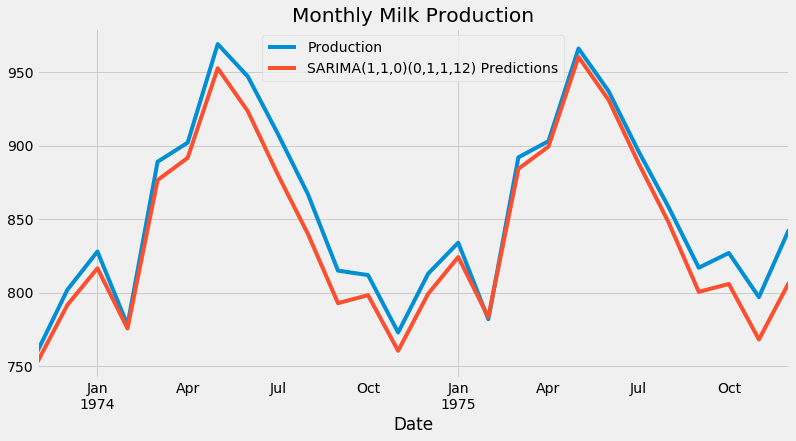

In [57]:
# Plot predictions against known values
title = 'Monthly Milk Production'
ax = test['Production'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [58]:
r2_score(test['Production'], predictions)

0.9240433686806808

In [59]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Production'])/np.abs(test['Production']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.924043,14.062889,274.940645,1.649905


# Future Forecasts

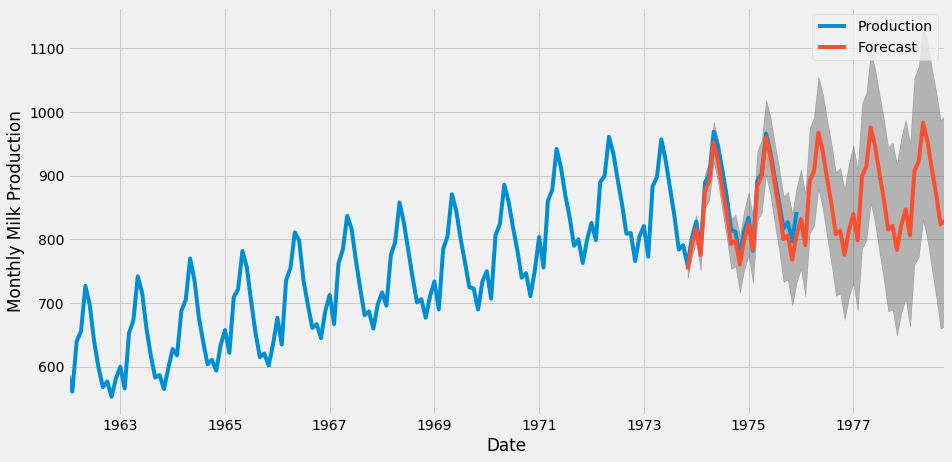

In [60]:
pred_f = results.get_forecast(steps=60)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Milk Production')
plt.legend()
plt.show()